In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.feature_selection import SelectFromModel

import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
from aux_func import evaluate_model

In [3]:
xtrain = pd.read_parquet("../data/xtrain.parquet")
ytrain = pd.read_parquet("../data/ytrain.parquet")['fatality']
xtest = pd.read_parquet("../data/xtest.parquet")
ytest = pd.read_parquet("../data/ytest.parquet")['fatality']

# Selección de Variables

## Regularización Lasso

In [10]:
sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', 
                                          solver='liblinear'), threshold = 0.1) # jugar con el threshold
sel_lasso.fit(xtrain, ytrain)

In [ ]:
selected_feat = xtrain.columns[sel_lasso.get_support()]
selected_feat

NameError: name 'sel_lasso' is not defined

In [ ]:
print('total features: {}'.format((xtrain.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 28
selected features: 24


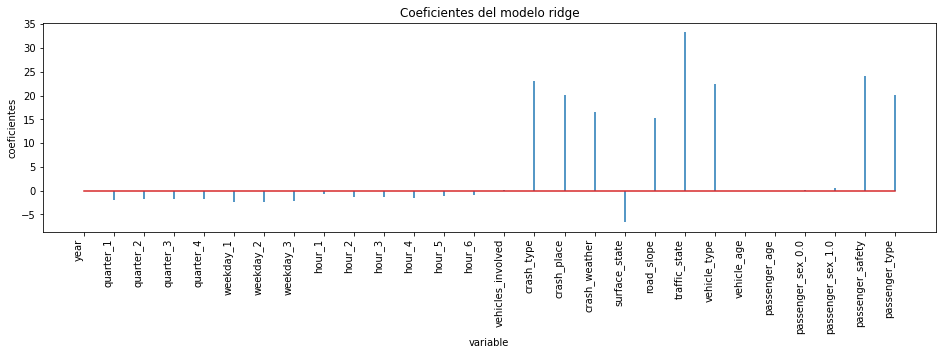

In [ ]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': xtrain.columns,
                         'coef': sel_lasso.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

# Regresión Logística con penalización L2 (Ridge)

In [4]:
%%time
clf = LogisticRegressionCV(cv=15, random_state=0, n_jobs=4, penalty='l2')
clf.fit(xtrain[selected_feat], ytrain)

NameError: name 'selected_feat' is not defined

In [ ]:
with open('../models/LR.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [ ]:
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
with open('../models/LR.pickle', 'rb') as f:
    clf = pickle.load(f)

In [5]:
ypred = clf.predict(xtest[selected_feat])
ypred_proba = clf.predict_proba(xtest[selected_feat])

NameError: name 'selected_feat' is not defined

In [6]:
evaluate_model(ytest,ypred, ypred_proba)

NameError: name 'ypred' is not defined

## Change Threshold

In [7]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

NameError: name 'ypred_proba' is not defined

# Regresión Logística con penalización L1 (Lasso)

In [ ]:
%%time
clf = LogisticRegressionCV(cv=10, random_state=0, n_jobs=3, penalty='l1', solver='liblinear')
clf.fit(xtrain[selected_feat], ytrain)

In [ ]:
with open('../models/LRlasso.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [ ]:
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
with open('../models/LRlasso.pickle', 'rb') as f:
    clf = pickle.load(f)

In [ ]:
ypred = clf.predict(xtest[selected_feat])
ypred_proba = clf.predict_proba(xtest[selected_feat])

In [ ]:
evaluate_model(ytest, ypred, ypred_proba)

## Change threshold

In [ ]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

NameError: name 'ypred_proba' is not defined